# MaskRcnn for article localization


I took Mark Rcnn is because, it is a kind of widely used in Instance segmentation

Mask R-CNN is simple to train and adds only a small overhead to Faster R-CNN, running at 5 fps.

Mask rcnn works with tensorflow 1.x

In [ ]:
!pip install tensorflow==1.15.0

In [ ]:
!pip install keras==2.1.5

In [1]:
import os
import gc
import sys
import json
import glob
import random
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold

Using TensorFlow backend.


In [2]:
print(tf.__version__)
print(keras.__version__)

1.15.0
2.1.5


## Data

I took data from "imaterialist-fashion-2019-FGVC6" kaggle competetion.

In [6]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.128 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-IN,en-GB;q=0.9,en-US;q=0.8,en;q=0.7" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/13032/862545/compressed/train.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1619337466&Signature=nvdLwfDZFSNAFG21H0I7u4yFyejVgxt931FohrPfCHu%2FNeBum1CoAFhBFIJDBReBEiVOYiRL17SvsYvMe8%2BybSkfdPM0YF3gbN9CRuVrD3eMiTr7swENvrUGZ3GuullkH5QxjlK%2FWiHGpwMaPJkOdU6MaO8BjXyHMRuZrj5u1B7iZbDz04jE97Z7RvonthVa15jCG1cWXnmSLrewc1pkc001S1BJ2hruBesVO7TLiRGQDrWthQxgW7fpmcADMVhxEmq94aSd686XM7URgD%2BwNXh8xyax4qcJp0M44hJmgbBI3Q8lYJPJvvfuxxiqLk5FfFiRPvLmHGKojRGpsTntJw%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.zip" -c -O 'train.zip'

--2021-04-22 07:58:05--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/13032/862545/compressed/train.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1619337466&Signature=nvdLwfDZFSNAFG21H0I7u4yFyejVgxt931FohrPfCHu%2FNeBum1CoAFhBFIJDBReBEiVOYiRL17SvsYvMe8%2BybSkfdPM0YF3gbN9CRuVrD3eMiTr7swENvrUGZ3GuullkH5QxjlK%2FWiHGpwMaPJkOdU6MaO8BjXyHMRuZrj5u1B7iZbDz04jE97Z7RvonthVa15jCG1cWXnmSLrewc1pkc001S1BJ2hruBesVO7TLiRGQDrWthQxgW7fpmcADMVhxEmq94aSd686XM7URgD%2BwNXh8xyax4qcJp0M44hJmgbBI3Q8lYJPJvvfuxxiqLk5FfFiRPvLmHGKojRGpsTntJw%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 108.177.125.128, 74.125.23.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18956138092 (18G) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[==============

In [7]:
!unzip train.zip

!rm -rf train.zip

In [5]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.128 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-IN,en-GB;q=0.9,en-US;q=0.8,en;q=0.7" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/13032/862545/compressed/train.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1619337418&Signature=VXcCR4dr3rsROFQkXQxXxvs1O162NSjKsWiNxGZ8%2FlJNhU6bmFfbN2ZAeyBc0RWbT3pMJSE9Ef6e07kccZmoFVuCPwBcLb%2F%2BKZxSgCaVt0ifPS7tMHjb6ip89gUNcgb6CGThIAKiZnFOoKE8T%2FN0qkh5dw1ZBgtKZIzs2xTziL0kM%2F1FXDmxQ%2BNYznaX0P4Ap428ZLTE99BQ5rcy%2FiOuazho5me3QjWSdIXeq6gtutZjKTtveoEd4cR%2BOEH5LHiI%2BBOWzu9XPK4ffQI5rMN%2B4LZGCOgsz9b2nvFiBiBwLS8wusOcn7TW1J0BPU3WyUCsbacCWXltth4laPgnX7fEFg%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.csv.zip" -c -O 'train.csv.zip'

--2021-04-22 07:57:13--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/13032/862545/compressed/train.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1619337418&Signature=VXcCR4dr3rsROFQkXQxXxvs1O162NSjKsWiNxGZ8%2FlJNhU6bmFfbN2ZAeyBc0RWbT3pMJSE9Ef6e07kccZmoFVuCPwBcLb%2F%2BKZxSgCaVt0ifPS7tMHjb6ip89gUNcgb6CGThIAKiZnFOoKE8T%2FN0qkh5dw1ZBgtKZIzs2xTziL0kM%2F1FXDmxQ%2BNYznaX0P4Ap428ZLTE99BQ5rcy%2FiOuazho5me3QjWSdIXeq6gtutZjKTtveoEd4cR%2BOEH5LHiI%2BBOWzu9XPK4ffQI5rMN%2B4LZGCOgsz9b2nvFiBiBwLS8wusOcn7TW1J0BPU3WyUCsbacCWXltth4laPgnX7fEFg%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 74.125.23.128, 74.125.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 571573081 (545M) [application/zip]
Saving to: ‘train.csv.zip’

train.csv.zip  

In [9]:
!unzip train.csv.zip

!rm -rf train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


### Train_test_split

In [8]:
with open('/content/label_descriptions.json') as f:
    label_descriptions = json.load(f)

label_names = [x['name'] for x in label_descriptions['categories']]
print(len(label_names),label_names[:5])

46 ['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket']


In [14]:
data = pd.read_csv('/content/train.csv')
data['Category'] = data['ClassId'].str.split('_').str[0]
data.head(3)

,ImageId,EncodedPixels,Height,Width,ClassId,Category
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,28


In [11]:
# total categories is 46
categories = 46
# the image size is set to 512, which is the same as the size of submission masks
img_size = 512

# Cloning the mask_rcnn model from git
!git clone https://www.github.com/matterport/Mask_RCNN.git

# As we have to use the few functions with in mrcnn direction. appending path to Mask_RCNN
os.chdir('Mask_RCNN')
sys.path.append('Mask_RCNN')

# importing required .py files from mrcnn directory 
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Cloning coco weights to train the images.
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = 'mask_rcnn_coco.h5'

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 23.25 MiB/s, done.
Resolving deltas: 100% (562/562), done.
-rw-r--r-- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


## Set Config
Mask R-CNN has a load of hyperparameters. Here I am adjusting based on the GPU count in my Google Colab ( 1 GPU )



In [12]:
# https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/config.py
# Overwarign the existing config file with our requirements
class FashionConfig(Config):
    NAME = "Article localization"  # Override in sub-classes
    
    # Number of classification classes (including background)
    NUM_CLASSES = 46 + 1 # +1 for the background class
    
    # NUMBER OF GPUs to use. When using only a CPU, this needs to be set to 1.
    GPU_COUNT = 1

    # Number of images to train with on each GPU. A 12GB GPU can typically
    # handle 2 images of 1024x1024px.
    # Adjust based on your GPU memory and image sizes. Use the highest
    # number that your GPU can handle for best performance.
    IMAGES_PER_GPU = 4 # a memory error occurs when IMAGES_PER_GPU is too high , 4 because image size is 512x512
    
    # Backbone network architecture
    # Supported values are: resnet50, resnet101.
    BACKBONE = 'resnet50'
    
    # Image shape
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512    
    IMAGE_RESIZE_MODE = 'none'

    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    
    # Number of training steps per epoch
    # This doesn't need to match the size of the training set. Tensorboard
    STEPS_PER_EPOCH = 1000

    # Number of validation steps to run at the end of every training epoch.
    # A bigger number improves accuracy of validation stats, but slows
    # down the training.
    VALIDATION_STEPS = 200
    
config = FashionConfig()

## Creating custome Dataset

https://towardsdatascience.com/mask-rcnn-implementation-on-a-custom-dataset-fd9a878123d4

https://github.com/shreyas90999/buy_me_that_look/blob/main/CS2_Module_2.ipynb

In [ ]:
def resize_image(image_path):
    image = cv2.imread(image_path)
    ## Changing Image from BLUE_Greenn_Red to Red_Green_Blue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ## Resizing Image
    image = cv2.resize(image, (512, 512), interpolation=cv2.INTER_AREA)  
    return image


class FashionDataset(utils.Dataset):
    # Giving data as per the Maskrcnn git
    def __init__(self, fashion_data):
        super().__init__(self)
        
        # Add classes
        for i, name in enumerate(label_names):
            # self.add_class("object", 3, "xyz") #likewise
            self.add_class("Article localization", i+1, name)
        
        # Add images 
        for i, row in fashion_data.iterrows():
            self.add_image("Article localization", image_id=row.name, path=str('/content/train/'+row.name), labels=row['Category'],annotations=row['EncodedPixels'], height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [label_names[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((512, 512, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (512, 512), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)

data_s = FashionDataset(image_df)
data_s.prepare()


In [ ]:
# Spilting Train and test data
FOLD = 0
from sklearn.model_selection import StratifiedKFold, KFold
data_fold = KFold(n_splits=5, random_state=0, shuffle=True)
data_splits = data_fold.split(image_df) 

def get_fold():    
    for i, (train, validation) in enumerate(data_splits):
        if i == FOLD:
            return image_df.iloc[train], image_df.iloc[validation]
        
train, valid = get_fold()

train_data = FashionDataset(train)
train_data.prepare()

valid_data = FashionDataset(valid)
valid_data.prepare()

In [ ]:
maskrcnn_model = modellib.MaskRCNN(mode='training', config=config, model_dir='content')
maskrcnn_model.set_log_dir(model_path='/content/Mask_RCNN/mrcnn')
maskrcnn_model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=['mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])

In [ ]:
from imgaug import augmenters as iaa
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5) # only horizontal flip here
])

In [ ]:
import keras

checkpoint = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Applied AI Course/Assignments/29. Self Case Study 2/Models/mask_rcnn_fashion_{epoch:04d}-{val_mrcnn_mask_loss:.5f}.h5',save_weights_only=True,verbose=1)
maskrcnn_model.train(train_data, valid_data,
            learning_rate=1e-4,
            epochs=10,
            layers='all',
            augmentation=augmentation,custom_callbacks=[checkpoint])

In [ ]:
maskrcnn_model = modellib.MaskRCNN(mode='training', config=config, model_dir='content')
maskrcnn_model.set_log_dir(model_path='/content/Mask_RCNN/mrcnn')
maskrcnn_model.load_weights('/content/drive/MyDrive/Applied AI Course/Assignments/29. Self Case Study 2/Models/mask_rcnn_fashion_0004-0.40588.h5', by_name=True)

checkpoint = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Applied AI Course/Assignments/29. Self Case Study 2/Models/mask_rcnn_fashion_day_2_{epoch:04d}-{val_mrcnn_mask_loss:.5f}.h5',save_weights_only=True,verbose=1)
maskrcnn_model.train(train_data, valid_data,
            learning_rate=1e-4,
            epochs=10,
            layers='all',
            augmentation=augmentation,custom_callbacks=[checkpoint])


Starting at epoch 0. LR=0.0001

Checkpoint Path: content/fashion20210407T0317/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (Ba

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessi

Epoch 1/10
 999/1000 [============================>.] - ETA: 2s - loss: 2.2040 - rpn_class_loss: 0.0741 - rpn_bbox_loss: 0.9583 - mrcnn_class_loss: 0.4237 - mrcnn_bbox_loss: 0.3532 - mrcnn_mask_loss: 0.3947

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


1000/1000 [==============================] - 3486s 3s/step - loss: 2.2036 - rpn_class_loss: 0.0740 - rpn_bbox_loss: 0.9581 - mrcnn_class_loss: 0.4237 - mrcnn_bbox_loss: 0.3532 - mrcnn_mask_loss: 0.3947 - val_loss: 2.0781 - val_rpn_class_loss: 0.0690 - val_rpn_bbox_loss: 0.8829 - val_mrcnn_class_loss: 0.4060 - val_mrcnn_bbox_loss: 0.3446 - val_mrcnn_mask_loss: 0.3755


Epoch 00001: saving model to /content/drive/MyDrive/Applied AI Course/Assignments/29. Self Case Study 2/Models/mask_rcnn_fashion_day_2_0001-0.37551.h5
Epoch 2/10
1000/1000 [==============================] - 3376s 3s/step - loss: 2.1042 - rpn_class_loss: 0.0695 - rpn_bbox_loss: 0.9136 - mrcnn_class_loss: 0.4067 - mrcnn_bbox_loss: 0.3384 - mrcnn_mask_loss: 0.3760 - val_loss: 2.1006 - val_rpn_class_loss: 0.0735 - val_rpn_bbox_loss: 0.9303 - val_mrcnn_class_loss: 0.3923 - val_mrcnn_bbox_loss: 0.3360 - val_mrcnn_mask_loss: 0.3686

Epoch 00002: saving model to /content/drive/MyDrive/Applied AI Course/Assignments/29. Self Case S

In [ ]:
maskrcnn_model = modellib.MaskRCNN(mode='training', config=config, model_dir='content')
maskrcnn_model.set_log_dir(model_path='/content/Mask_RCNN/mrcnn')
maskrcnn_model.load_weights('/content/drive/MyDrive/Applied AI Course/Assignments/29. Self Case Study 2/Models/mask_rcnn_fashion_day_2_0002-0.36857.h5', by_name=True)

checkpoint = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Applied AI Course/Assignments/29. Self Case Study 2/Models/mask_rcnn_fashion_day_2_1_{epoch:04d}-{val_mrcnn_mask_loss:.5f}.h5',save_weights_only=True,verbose=1)
maskrcnn_model.train(train_data, valid_data,
            learning_rate=1e-4,
            epochs=7,
            layers='all',
            augmentation=augmentation,custom_callbacks=[checkpoint])


Starting at epoch 0. LR=0.0001

Checkpoint Path: content/fashion20210407T0638/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (Ba

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/7
 999/1000 [============================>.] - ETA: 2s - loss: 2.0714 - rpn_class_loss: 0.0684 - rpn_bbox_loss: 0.9070 - mrcnn_class_loss: 0.4016 - mrcnn_bbox_loss: 0.3281 - mrcnn_mask_loss: 0.3663

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


1000/1000 [==============================] - 3770s 4s/step - loss: 2.0709 - rpn_class_loss: 0.0684 - rpn_bbox_loss: 0.9067 - mrcnn_class_loss: 0.4015 - mrcnn_bbox_loss: 0.3281 - mrcnn_mask_loss: 0.3663 - val_loss: 2.1141 - val_rpn_class_loss: 0.0708 - val_rpn_bbox_loss: 0.9677 - val_mrcnn_class_loss: 0.3971 - val_mrcnn_bbox_loss: 0.3202 - val_mrcnn_mask_loss: 0.3582


Epoch 00001: saving model to /content/drive/MyDrive/Applied AI Course/Assignments/29. Self Case Study 2/Models/mask_rcnn_fashion_day_2_1_0001-0.35817.h5
Epoch 2/7
1000/1000 [==============================] - 3357s 3s/step - loss: 2.0443 - rpn_class_loss: 0.0673 - rpn_bbox_loss: 0.9145 - mrcnn_class_loss: 0.3878 - mrcnn_bbox_loss: 0.3203 - mrcnn_mask_loss: 0.3543 - val_loss: 2.0896 - val_rpn_class_loss: 0.0694 - val_rpn_bbox_loss: 0.9898 - val_mrcnn_class_loss: 0.3647 - val_mrcnn_bbox_loss: 0.3185 - val_mrcnn_mask_loss: 0.3472

Epoch 00002: saving model to /content/drive/MyDrive/Applied AI Course/Assignments/29. Self Case 

In [ ]:
maskrcnn_model = modellib.MaskRCNN(mode='training', config=config, model_dir='content')
maskrcnn_model.set_log_dir(model_path='/content/Mask_RCNN/mrcnn')
maskrcnn_model.load_weights('/content/drive/MyDrive/Applied AI Course/Assignments/29. Self Case Study 2/Models/mask_rcnn_fashion_day_2_1_0003-0.34180.h5', by_name=True)

checkpoint = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Applied AI Course/Assignments/29. Self Case Study 2/Models/mask_rcnn_fashion_day_2_2_{epoch:04d}-{val_mrcnn_mask_loss:.5f}.h5',save_weights_only=True,verbose=1)
maskrcnn_model.train(train_data, valid_data,
            learning_rate=1e-4,
            epochs=4,
            layers='all',
            augmentation=augmentation,custom_callbacks=[checkpoint])


Starting at epoch 0. LR=0.0001

Checkpoint Path: content/fashion20210407T1039/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (Ba

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessi

Epoch 1/4
 999/1000 [============================>.] - ETA: 2s - loss: 1.9591 - rpn_class_loss: 0.0629 - rpn_bbox_loss: 0.8659 - mrcnn_class_loss: 0.3819 - mrcnn_bbox_loss: 0.3067 - mrcnn_mask_loss: 0.3418

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


1000/1000 [==============================] - 3561s 4s/step - loss: 1.9588 - rpn_class_loss: 0.0629 - rpn_bbox_loss: 0.8654 - mrcnn_class_loss: 0.3820 - mrcnn_bbox_loss: 0.3067 - mrcnn_mask_loss: 0.3418 - val_loss: 1.9717 - val_rpn_class_loss: 0.0684 - val_rpn_bbox_loss: 0.8952 - val_mrcnn_class_loss: 0.3637 - val_mrcnn_bbox_loss: 0.3059 - val_mrcnn_mask_loss: 0.3386


Epoch 00001: saving model to /content/drive/MyDrive/Applied AI Course/Assignments/29. Self Case Study 2/Models/mask_rcnn_fashion_day_2_2_0001-0.33859.h5
Epoch 2/4
1000/1000 [==============================] - 3206s 3s/step - loss: 1.9699 - rpn_class_loss: 0.0642 - rpn_bbox_loss: 0.8859 - mrcnn_class_loss: 0.3788 - mrcnn_bbox_loss: 0.3024 - mrcnn_mask_loss: 0.3387 - val_loss: 1.9602 - val_rpn_class_loss: 0.0644 - val_rpn_bbox_loss: 0.8935 - val_mrcnn_class_loss: 0.3633 - val_mrcnn_bbox_loss: 0.3021 - val_mrcnn_mask_loss: 0.3369

Epoch 00002: saving model to /content/drive/MyDrive/Applied AI Course/Assignments/29. Self Case 

As there is power cuts in my village area I run the code multiple times with different weights. So, final plot is just for 4 epochs but the output of the maskrcnn model very good. 

Model neither overfit nor under. 

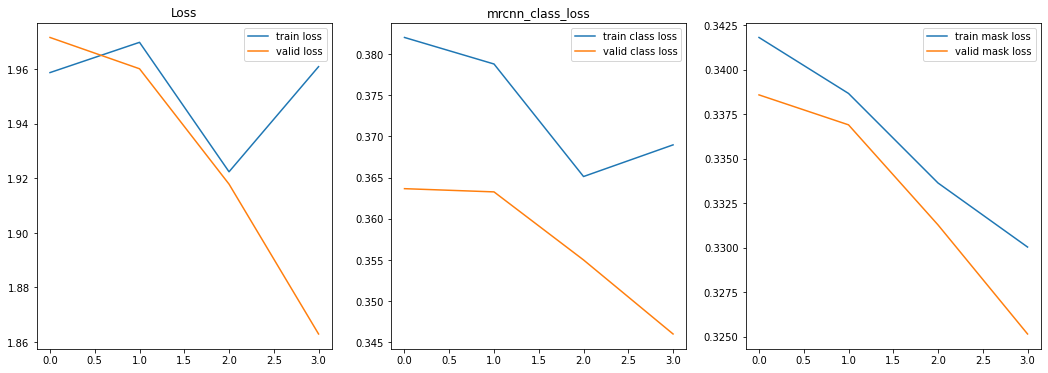

In [ ]:
epochs = range(4)
plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.plot(epochs, history['loss'], label="train loss")
plt.plot(epochs, history['val_loss'], label="valid loss")
plt.title("Loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history['mrcnn_class_loss'], label="train class loss")
plt.plot(epochs, history['val_mrcnn_class_loss'], label="valid class loss")
plt.title('mrcnn_class_loss')
plt.legend()
plt.subplot(133)
plt.plot(epochs, history['mrcnn_mask_loss'], label="train mask loss")
plt.plot(epochs, history['val_mrcnn_mask_loss'], label="valid mask loss")
plt.legend()

plt.show()

In [17]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## As we are validating one image at one, Again modifying the config file. 
class InferenceConfig(FashionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

maskrcnn_model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir='/content/')

model_path ='/content/drive/MyDrive/Applied AI Course/Assignments/29. Self Case Study 2/mask_rcnn_fashion_day_2_2_0004-0.32516.h5'


maskrcnn_model.load_weights(model_path, by_name=True)#load trained model

In [ ]:
for image in image_list_:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    result = maskrcnn_model.detect([resize_image(image_path)])
    roi = result[0]
    
    if roi['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], roi['masks'].shape[-1]), dtype=np.uint8)
        for m in range(roi['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(roi['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = img.shape[0]/512
        x_scale = img.shape[1]/512
        rois = (roi['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
    else:
        masks, rois = roi['masks'], roi['rois']
        
    visualize.display_instances(img, rois, masks, roi['class_ids'], 
                                ['bg']+label_names, roi['scores'],
                                title=image, figsize=(12, 12))
    # Img , region of interest, mask , roi class, roi label name, confidence score of label , title and dispaly figure size

Output hidden; open in https://colab.research.google.com to view.